In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
import xgboost 
from matplotlib import pyplot
from sklearn import set_config
set_config(transform_output="pandas")


In [2]:
data_path = "Dataset_analyse.csv"
df = pd.read_csv(data_path)

df = df.drop(['score','month','day',"title","total_spectator",'director',"copies","hebdo_rank","first_day","first_weekend","rating_public","casting","visa","award","lang"], axis=1)
df = df.dropna()

df

,year,country,duration,genre,first_week,distributor,rating_press,budget,entree_annee,classification_acteurs,classification_country,is_holiday
0,1997,france,6300,thriller,172230,2,3.28,89400000.0,149.3,0.0,2,0
1,1999,france,5400,drame,154881,3,3.40,165600000.0,153.6,0.0,2,0
2,1994,france,5220,comedie,417021,3,2.70,906030000.0,124.4,2.0,2,0
3,1995,etatsunis,9900,aventure action,355642,3,2.60,208200000.0,130.2,0.0,3,0
4,1994,russie,9120,comedie dramatique,101953,3,3.14,131000000.0,124.4,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3627,1997,etatsunis,5520,film familial,129374,3,3.30,100200000.0,149.3,0.0,3,0
3628,1994,etatsunis,6060,aventure action,186581,3,3.30,100200000.0,124.4,0.0,3,0
3629,1994,etatsunis,6480,film familial,227393,3,3.00,492240000.0,132.7,0.0,3,0
3630,2008,grandebretagne,7080,comedie,110442,3,3.90,283600000.0,190.3,0.0,0,1


In [3]:
X = df.drop(['first_week'], axis=1)
y = df.first_week

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42)

num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)

onehotscale_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False), RobustScaler(with_centering=False))
scale_pipeline = make_pipeline(RobustScaler(with_centering=False))

preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', onehotscale_pipeline, cat_col),
        ('numerical', scale_pipeline, num_col)]
)

polyscale_pipeline = make_pipeline(PolynomialFeatures(2))

my_final_pipeline = make_pipeline(preprocessing, polyscale_pipeline)
my_final_pipeline.fit(X_train)

feature_names = my_final_pipeline.get_feature_names_out(X.columns)

In [4]:
# from sklearn import set_config


# set_config(transform_output="pandas")
# model = make_pipeline(
#     my_final_pipeline,
# )
# xdata = model.fit_transform(X_train, y_train)
# xdata.head()

In [5]:
# model = make_pipeline(
#     my_final_pipeline,
#     Lasso(random_state=42, max_iter=100000),
#     # CatBoostClassifier(random_state=42, depth=6,verbose=False)
# )

# param_grid = {'lasso__alpha': [15]}
# # param_grid = {
# #     'catboostclassifier__n_estimators': [100, 200, 300],
# #     'catboostclassifier__depth': [4, 6, 8]   
# # }

# # grid_search = GridSearchCV(model, param_grid, cv=2, scoring='accuracy')
# # grid_search.fit(X_train, y_train)

# # model = GridSearchCV(model, param_grid,cv =5)
# model.fit(X_train, y_train)
# # grid_score = model.score(X_train, y_train)

# # best_alpha = model.best_params_['lasso__alpha']

In [6]:
model = make_pipeline(
    my_final_pipeline,
    xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    )

model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False)),
                                                                                   ('robustscaler',
                                                                                    RobustScaler(with_centering=False))]),
                                                                   ['country',
                                                                    'genre']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('robustscaler',
                                                                                    RobustScaler(with_centeri...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

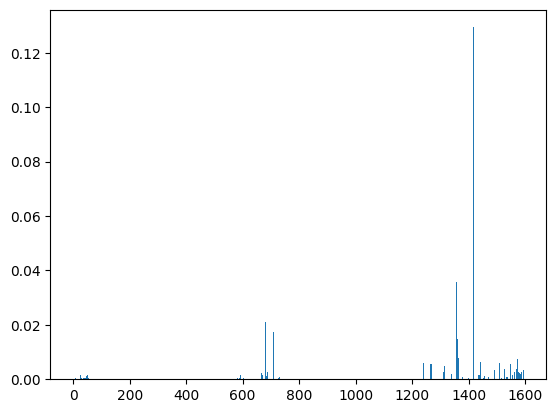

In [7]:
pyplot.bar(range(len(model[-1].feature_importances_)), model[-1].feature_importances_)
pyplot.show()

In [8]:
xtrain_tr = model[:-1].fit_transform(X_train)

In [9]:
xtrain_tr.columns

Index(['1', 'categorical__country_afrique du sud',
       'categorical__country_allemagne', 'categorical__country_argentine',
       'categorical__country_australie', 'categorical__country_belgique',
       'categorical__country_canada', 'categorical__country_chine',
       'categorical__country_coree du sud', 'categorical__country_danemark',
       ...
       'numerical__entree_annee^2',
       'numerical__entree_annee numerical__classification_acteurs',
       'numerical__entree_annee numerical__classification_country',
       'numerical__entree_annee numerical__is_holiday',
       'numerical__classification_acteurs^2',
       'numerical__classification_acteurs numerical__classification_country',
       'numerical__classification_acteurs numerical__is_holiday',
       'numerical__classification_country^2',
       'numerical__classification_country numerical__is_holiday',
       'numerical__is_holiday^2'],
      dtype='object', length=1596)

In [10]:
pd.Series(model[-1].feature_importances_, index = xtrain_tr.columns)

1                                                                      0.000000
categorical__country_afrique du sud                                    0.000081
categorical__country_allemagne                                         0.000043
categorical__country_argentine                                         0.000110
categorical__country_australie                                         0.000147
                                                                         ...   
numerical__classification_acteurs numerical__classification_country    0.013997
numerical__classification_acteurs numerical__is_holiday                0.012575
numerical__classification_country^2                                    0.000000
numerical__classification_country numerical__is_holiday                0.003390
numerical__is_holiday^2                                                0.000000
Length: 1596, dtype: float32

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

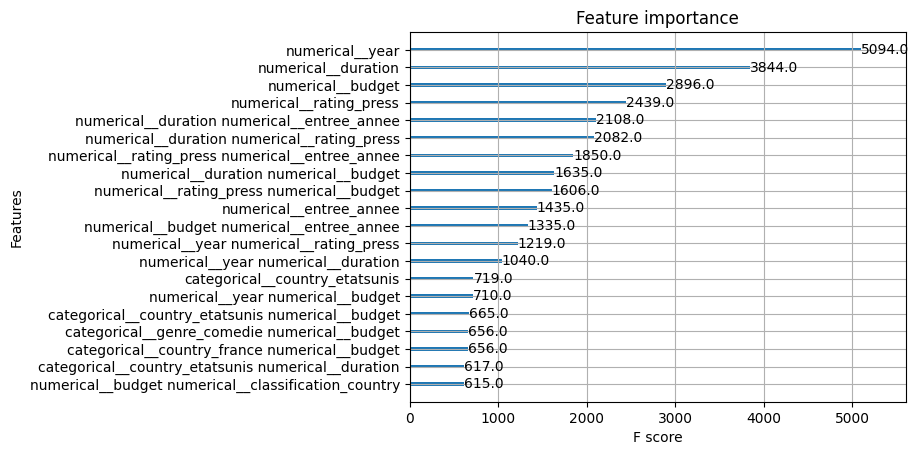

In [11]:
xgboost.plot_importance(model[-1], max_num_features=20)

In [12]:
# y_pred_train = model.predict(X_train)


# residus =  y_pred_train - y_train


# weights = np.exp(-abs(residus) / residus.std())
# model.fit(X_train, y_train, lasso__sample_weight=weights)




y_pred = model.predict(X_test)
# y_pred = model.predict(df_test)
# print(y_pred)

In [13]:

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

Performance du modèle :
R2 Score: 0.2050
MAE: 221068.29
RMSE: 364845.01


In [14]:
from joblib import dump, load

model_path = 'model.pkl'
dump(model, model_path)
model = load('model.pkl')

In [15]:
def predict_prod(model,data):
    # Convertir la liste de listes en DataFrame
    df = pd.DataFrame(data, columns=['year', 'entree_annee','is_holiday','month','day','director', 'country','classification_country','classification_acteurs' ,'duration', 'genre', 'copies', 'rating_press','budget','distributor'])
    predictions = model.predict(df)
    return predictions

predict_prod(model,[[2023, 180.8,1,7, 19, 1, "etatsunis",3,3, 6840, "film familial", 665, 3.4, 100000000, 3]])

array([874776.4], dtype=float32)